### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Instructions for running this notebook

Instructions for downloading the raw data are in the [google_research/batch_science](https://github.com/google-research/google-research/tree/master/batch_science) GitHub repository.

To run this notebook using the downloaded data, you will need to clone the [google-research](https://github.com/google-research/google-research.git) GitHub repository, install required dependencies, and start a local Jupyter server:

```bash
# Install/upgrade required Python packages.
pip install --upgrade jupyter matplotlib numpy pandas

# Clone google-research repository and move into the directory.
git clone https://github.com/google-research/google-research.git
cd google-research

# Start Jupyter as a Colab server (see https://research.google.com/colaboratory/local-runtimes.html)
pip install jupyter_http_over_ws
jupyter serverextension enable --py jupyter_http_over_ws
jupyter notebook \
  --NotebookApp.allow_origin='https://colab.research.google.com' \
  --port=8888 \
  --NotebookApp.port_retries=0

# Now connect this notebook to the local server.
```

Note that some plots (primarily for MNIST) look slightly different from those in the paper due to arbitrary differences in which 100 completed trials were selected for each batch size.

# Measuring the Effects of Data Parallelism on Neural Network Training

This notebook reproduces all plots in the main section of the paper [**"Measuring the Effects of Data Parallelism on Neural Network Training"**](
https://arxiv.org/abs/1811.03600).

In [0]:
#@title Imports and Setup

from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import collections
import os.path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load helper functions.
try:
  from batch_science.data_loader import load_workload
except ImportError as e:
  raise ImportError(
      "{}. Ensure you are running the Jupyter server from the google_research "
      "directory.".format(e))
  
from batch_science.measurement_utils import apply_example_budget
from batch_science.measurement_utils import apply_step_budget
from batch_science.measurement_utils import compute_steps_to_result
from batch_science.measurement_utils import get_best_measurement
from batch_science.plot_utils import create_subplots
from batch_science.plot_utils import plot_best_measurements
from batch_science.plot_utils import plot_learning_rate_momentum_scatter
from batch_science.plot_utils import plot_optimal_metaparameter_values
from batch_science.plot_utils import plot_steps_to_result

# Customize matplotlib style.
plt.style.use('seaborn-deep')
matplotlib.rcParams['axes.titlesize'] = 10
matplotlib.rcParams['axes.labelsize'] = 9
matplotlib.rcParams['xtick.labelsize'] = 8
matplotlib.rcParams['ytick.labelsize'] = 8
matplotlib.rcParams['legend.fontsize'] = 8
  
# Directory containing extracted data.
DATA_DIR = "/tmp/batch_science"  #@param

Loaded 10 batch sizes for simple_cnn_base on mnist with optimizer nesterov_momentum
Loaded 9 batch sizes for simple_cnn_base on fashion_mnist with optimizer nesterov_momentum
Loaded 13 batch sizes for resnet_8 on cifar_10 with optimizer nesterov_momentum
Loaded 11 batch sizes for resnet_50 on imagenet with optimizer nesterov_momentum
Loaded 10 batch sizes for resnet_50 on open_images_v4 with optimizer nesterov_momentum
Loaded 12 batch sizes for transformer_base on lm1b with optimizer nesterov_momentum
Loaded 6 batch sizes for transformer_base on common_crawl with optimizer nesterov_momentum
Loaded 11 batch sizes for vgg_11 on imagenet with optimizer nesterov_momentum
Loaded 7 batch sizes for lstm on lm1b with optimizer nesterov_momentum


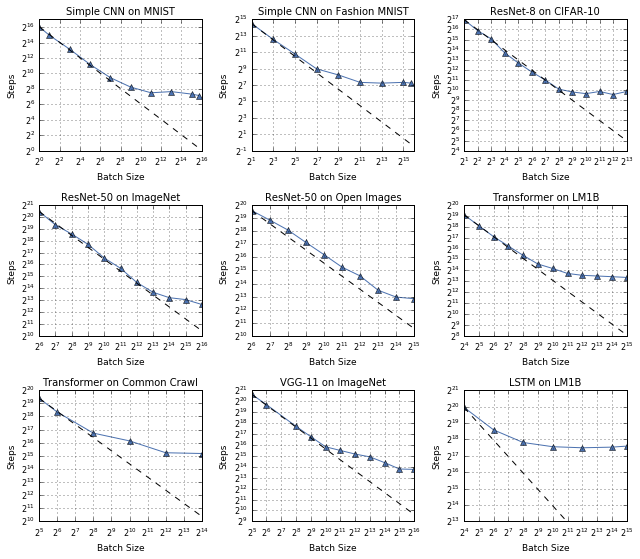

In [17]:
#@title Figure 1

fig, axes = create_subplots(3, 3)

# Simple CNN on MNIST.
workload_dir = os.path.join(DATA_DIR, "mnist/simple_cnn_base/nesterov_momentum")
_, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result = compute_steps_to_result(workload_table, "val/classification_error", 0.01)
plot_steps_to_result(axes[0][0], steps_to_result)
axes[0][0].set_title("Simple CNN on MNIST")

# Simple CNN on Fashion MNIST.
workload_dir = os.path.join(DATA_DIR, "fashion_mnist/simple_cnn_base/nesterov_momentum")
_, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result = compute_steps_to_result(workload_table, "val/classification_error", 0.1)
plot_steps_to_result(axes[0][1], steps_to_result)
axes[0][1].set_title("Simple CNN on Fashion MNIST")

# ResNet-8 on CIFAR-10.
workload_dir = os.path.join(DATA_DIR, "cifar_10/resnet_8/nesterov_momentum")
_, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result = compute_steps_to_result(workload_table, "val/classification_error", 0.3)
plot_steps_to_result(axes[0][2], steps_to_result)
axes[0][2].set_title("ResNet-8 on CIFAR-10")

# ResNet-50 on ImageNet.
workload_dir = os.path.join(DATA_DIR, "imagenet/resnet_50/nesterov_momentum")
_, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result = compute_steps_to_result(workload_table, "val/classification_error", 0.25)
plot_steps_to_result(axes[1][0], steps_to_result)
axes[1][0].set_title("ResNet-50 on ImageNet")

# ResNet-50 on Open Images.
workload_dir = os.path.join(DATA_DIR, "open_images_v4/resnet_50/nesterov_momentum")
_, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result = compute_steps_to_result(workload_table, "val/average_precision", 0.31, maximize=True)
plot_steps_to_result(axes[1][1], steps_to_result)
axes[1][1].set_title("ResNet-50 on Open Images")

# Transformer on LM1B.
workload_dir = os.path.join(DATA_DIR, "lm1b/transformer_base/nesterov_momentum")
_, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result = compute_steps_to_result(workload_table, "val/cross_entropy_error", 3.9)
plot_steps_to_result(axes[1][2], steps_to_result)
axes[1][2].set_title("Transformer on LM1B")

# Transformer on Common Crawl.
workload_dir = os.path.join(DATA_DIR, "common_crawl/transformer_base/nesterov_momentum")
_, workload_table = load_workload(workload_dir, num_trials=50)
steps_to_result = compute_steps_to_result(workload_table, "val/cross_entropy_error", 3.9)
plot_steps_to_result(axes[2][0], steps_to_result)
axes[2][0].set_title("Transformer on Common Crawl")

# VGG-11 on ImageNet.
workload_dir = os.path.join(DATA_DIR, "imagenet/vgg_11/nesterov_momentum")
_, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result = compute_steps_to_result(workload_table, "val/classification_error", 0.35)
plot_steps_to_result(axes[2][1], steps_to_result)
axes[2][1].set_title("VGG-11 on ImageNet")

# LSTM on LM1B.
workload_dir = os.path.join(DATA_DIR, "lm1b/lstm/nesterov_momentum")
_, workload_table = load_workload(workload_dir, num_trials=50)
steps_to_result = compute_steps_to_result(workload_table, "val/cross_entropy_error", 3.9)
plot_steps_to_result(axes[2][2], steps_to_result)
axes[2][2].set_title("LSTM on LM1B")
axes[2][2].set_ylim([2**13, 2**21])

plt.tight_layout()

Loaded 10 batch sizes for simple_cnn_base on mnist with optimizer nesterov_momentum
Loaded 12 batch sizes for transformer_base on lm1b with optimizer nesterov_momentum
Loaded 11 batch sizes for resnet_50 on imagenet with optimizer nesterov_momentum


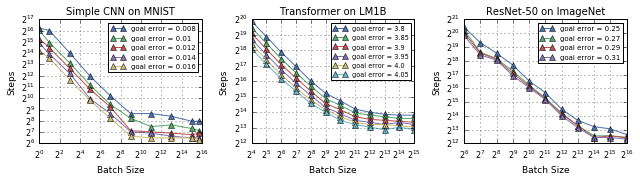

In [18]:
#@title Figure 2

fig, axes = create_subplots(1, 3)

# Simple CNN on MNIST.
workload_dir = os.path.join(DATA_DIR, "mnist/simple_cnn_base/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result = collections.OrderedDict()
for goal_error in [0.008, 0.01, 0.012, 0.014, 0.016]:
  steps_to_result["goal error = {}".format(goal_error)] = compute_steps_to_result(
        workload_table, "val/classification_error", goal_error)
plot_steps_to_result(axes[0], steps_to_result, add_scaling=False)
axes[0].set_title("Simple CNN on MNIST")
axes[0].legend(fontsize=7)

# Transformer on LM1B.
workload_dir = os.path.join(DATA_DIR, "lm1b/transformer_base/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result = collections.OrderedDict()
for goal_error in [3.8, 3.85, 3.9, 3.95, 4.0, 4.05]:
  steps_to_result["goal error = {}".format(goal_error)] = compute_steps_to_result(
        workload_table, "val/cross_entropy_error", goal_error)
plot_steps_to_result(axes[1], steps_to_result, add_scaling=False)
axes[1].set_title("Transformer on LM1B")
axes[1].legend(fontsize=6.5)

# ResNet-50 on ImageNet.
workload_dir = os.path.join(DATA_DIR, "imagenet/resnet_50/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result = collections.OrderedDict()
for goal_error in [0.25, 0.27, 0.29, 0.31]:
  steps_to_result["goal error = {}".format(goal_error)] = compute_steps_to_result(
        workload_table, "val/classification_error", goal_error)
plot_steps_to_result(axes[2], steps_to_result, add_scaling=False)
axes[2].set_title("ResNet-50 on ImageNet")
axes[2].legend(fontsize=7)

plt.tight_layout()

Loaded 17 batch sizes for fc_1024_1024_1024 on mnist with optimizer sgd
Loaded 17 batch sizes for simple_cnn_base on mnist with optimizer sgd
Loaded 11 batch sizes for resnet_50 on imagenet with optimizer nesterov_momentum
Loaded 11 batch sizes for vgg_11 on imagenet with optimizer nesterov_momentum
Loaded 12 batch sizes for transformer_base on lm1b with optimizer nesterov_momentum
Loaded 7 batch sizes for lstm on lm1b with optimizer nesterov_momentum
Loaded 17 batch sizes for fc_1024 on mnist with optimizer sgd
Loaded 17 batch sizes for fc_128_128_128 on mnist with optimizer sgd
Loaded 17 batch sizes for fc_256_256_256 on mnist with optimizer sgd
Loaded 17 batch sizes for fc_512_512_512 on mnist with optimizer sgd
Loaded 17 batch sizes for fc_1024_1024_1024 on mnist with optimizer sgd
Loaded 17 batch sizes for fc_2048_2048_2048 on mnist with optimizer sgd
Loaded 17 batch sizes for simple_cnn_base on mnist with optimizer sgd
Loaded 17 batch sizes for simple_cnn_narrow on mnist with opt

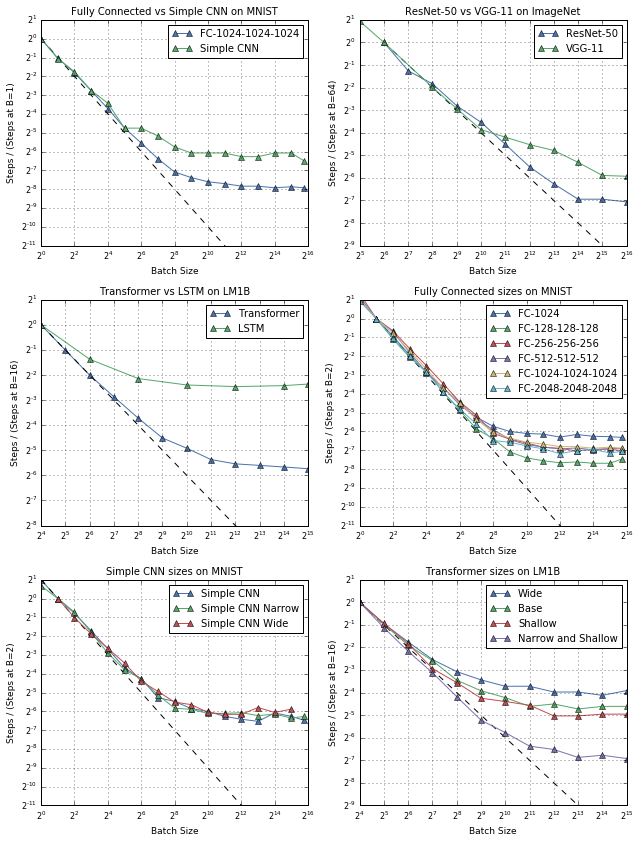

In [19]:
#@title Figure 3

fig, axes = create_subplots(3, 2)

# Fully Connected vs Simple CNN on MNIST.
steps_to_result = collections.OrderedDict()
for label, subdir in [("FC-1024-1024-1024", "fc_1024_1024_1024/sgd"), 
                      ("Simple CNN", "simple_cnn_base/sgd")]:
  _, workload_table = load_workload(os.path.join(DATA_DIR, "mnist", subdir), num_trials=100)
  steps_to_result[label] = compute_steps_to_result(workload_table, "val/classification_error", 0.03)
plot_steps_to_result(axes[0][0], steps_to_result, scaling_label="FC-1024-1024-1024", normalizing_batch_size=1)
axes[0][0].set_title("Fully Connected vs Simple CNN on MNIST")
axes[0][0].set_ylim([2**-11, 2])
axes[0][0].legend(fontsize=10)

# ResNet-50 vs VGG-11 on ImageNet.
steps_to_result = collections.OrderedDict()
for label, subdir in [("ResNet-50", "resnet_50/nesterov_momentum"),
                      ("VGG-11", "vgg_11/nesterov_momentum")]:
  _, workload_table = load_workload(os.path.join(DATA_DIR, "imagenet", subdir), num_trials=100)
  steps_to_result[label] = compute_steps_to_result(workload_table, "val/classification_error", 0.35)
plot_steps_to_result(axes[0][1], steps_to_result, scaling_label="ResNet-50", normalizing_batch_size=64)
axes[0][1].set_title("ResNet-50 vs VGG-11 on ImageNet")
axes[0][1].set_ylim([2**-9, 2])
axes[0][1].legend(fontsize=10)

# Transformer vs LSTM on LM1B.
steps_to_result = collections.OrderedDict()
workload_dir = os.path.join(DATA_DIR, "lm1b/transformer_base/nesterov_momentum")
_, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result["Transformer"] = compute_steps_to_result(workload_table, "val/cross_entropy_error", 3.9)
workload_dir = os.path.join(DATA_DIR, "lm1b/lstm/nesterov_momentum")
_, workload_table = load_workload(workload_dir, num_trials=50)
steps_to_result["LSTM"] = compute_steps_to_result(workload_table, "val/cross_entropy_error", 3.9)
plot_steps_to_result(axes[1][0], steps_to_result, scaling_label="Transformer", normalizing_batch_size=16)
axes[1][0].set_title("Transformer vs LSTM on LM1B")
axes[1][0].set_ylim([2**-8, 2])
axes[1][0].legend(fontsize=10)

# Fully Connected sizes on MNIST.
steps_to_result = collections.OrderedDict()
for label, subdir in [("FC-1024", "fc_1024/sgd"),
                      ("FC-128-128-128", "fc_128_128_128/sgd"),
                      ("FC-256-256-256", "fc_256_256_256/sgd"),
                      ("FC-512-512-512", "fc_512_512_512/sgd"),
                      ("FC-1024-1024-1024", "fc_1024_1024_1024/sgd"),
                      ("FC-2048-2048-2048", "fc_2048_2048_2048/sgd")]:
  _, workload_table = load_workload(os.path.join(DATA_DIR, "mnist", subdir), num_trials=100)
  steps_to_result[label] = compute_steps_to_result(workload_table, "val/classification_error", 0.03)
plot_steps_to_result(axes[1][1], steps_to_result, scaling_label="FC-1024", normalizing_batch_size=2)
axes[1][1].set_title("Fully Connected sizes on MNIST")
axes[1][1].set_ylim([2**-11, 2])
axes[1][1].legend(fontsize=10)

# Simple CNN sizes on MNIST.
steps_to_result = collections.OrderedDict()
for label, subdir in [("Simple CNN", "simple_cnn_base/sgd"),
                      ("Simple CNN Narrow", "simple_cnn_narrow/sgd"),
                      ("Simple CNN Wide", "simple_cnn_wide/sgd")]:
  _, workload_table = load_workload(os.path.join(DATA_DIR, "mnist", subdir), num_trials=100)
  steps_to_result[label] = compute_steps_to_result(workload_table, "val/classification_error", 0.01)
plot_steps_to_result(axes[2][0], steps_to_result, scaling_label="Simple CNN", normalizing_batch_size=2)
axes[2][0].set_title("Simple CNN sizes on MNIST")
axes[2][0].set_ylim([2**-11, 2])
axes[2][0].legend(fontsize=10)

# Transformer sizes on LM1B.
steps_to_result = collections.OrderedDict()
for label, subdir in [("Wide", "transformer_wide/nesterov_momentum"),
                      ("Base", "transformer_base/nesterov_momentum"),
                      ("Shallow", "transformer_shallow/nesterov_momentum"),
                      ("Narrow and Shallow", "transformer_narrow_and_shallow/nesterov_momentum")]:
  _, workload_table = load_workload(os.path.join(DATA_DIR, "lm1b", subdir), num_trials=100)
  steps_to_result[label] = compute_steps_to_result(workload_table, "val/cross_entropy_error", 4.2)
plot_steps_to_result(axes[2][1], steps_to_result, scaling_label="Wide", normalizing_batch_size=16)
axes[2][1].set_title("Transformer sizes on LM1B")
axes[2][1].set_ylim([2**-9, 2])
axes[2][1].legend(fontsize=10)

plt.tight_layout()

Loaded 17 batch sizes for simple_cnn_base on mnist with optimizer sgd
Loaded 17 batch sizes for simple_cnn_base on mnist with optimizer momentum
Loaded 10 batch sizes for simple_cnn_base on mnist with optimizer nesterov_momentum
Loaded 5 batch sizes for transformer_shallow on lm1b with optimizer sgd
Loaded 6 batch sizes for transformer_shallow on lm1b with optimizer momentum
Loaded 12 batch sizes for transformer_shallow on lm1b with optimizer nesterov_momentum
Loaded 13 batch sizes for resnet_8 on cifar_10 with optimizer sgd
Loaded 13 batch sizes for resnet_8 on cifar_10 with optimizer nesterov_momentum


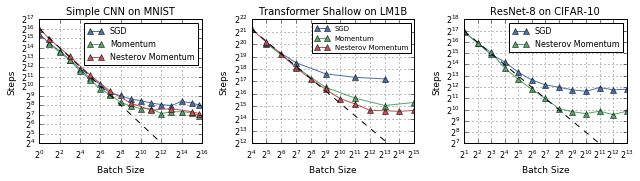

In [20]:
#@title Figure 4

fig, axes = create_subplots(1, 3)

# Simple CNN on MNIST.
steps_to_result = collections.OrderedDict()
for label, subdir in [("SGD", "sgd"), 
                      ("Momentum", "momentum"),
                      ("Nesterov Momentum", "nesterov_momentum")]:
  _, workload_table = load_workload(os.path.join(DATA_DIR, "mnist/simple_cnn_base", subdir), num_trials=100)
  steps_to_result[label] = compute_steps_to_result(workload_table, "val/classification_error", 0.01)
plot_steps_to_result(axes[0], steps_to_result, scaling_label="Nesterov Momentum")
axes[0].set_title("Simple CNN on MNIST")
axes[0].set_ylim([2**4, 2**17])
axes[0].legend()

# Transformer Shallow on LM1B.
steps_to_result = collections.OrderedDict()
for label, subdir in [("SGD", "sgd"), 
                      ("Momentum", "momentum"),
                      ("Nesterov Momentum", "nesterov_momentum")]:
  num_trials = 50 if subdir == "sgd" else 100
  _, workload_table = load_workload(os.path.join(DATA_DIR, "lm1b/transformer_shallow", subdir), num_trials=num_trials)
  steps_to_result[label] = compute_steps_to_result(workload_table, "val/cross_entropy_error", 3.9)
plot_steps_to_result(axes[1], steps_to_result, scaling_label="Nesterov Momentum")
axes[1].set_title("Transformer Shallow on LM1B")
axes[1].set_ylim([2**12, 2**22])
axes[1].legend(fontsize=7)


# ResNet-8 on CIFAR-10.
steps_to_result = collections.OrderedDict()
for label, subdir in [("SGD", "sgd"),  ("Nesterov Momentum", "nesterov_momentum")]:
  _, workload_table = load_workload(os.path.join(DATA_DIR, "cifar_10/resnet_8", subdir), num_trials=100)
  steps_to_result[label] = compute_steps_to_result(workload_table, "val/classification_error", 0.3)
plot_steps_to_result(axes[2], steps_to_result, scaling_label="Nesterov Momentum")
axes[2].set_title("ResNet-8 on CIFAR-10")
axes[2].set_ylim([2**7, 2**18])
axes[2].legend()

plt.tight_layout()

Loaded 10 batch sizes for simple_cnn_base on mnist with optimizer nesterov_momentum
Loaded 9 batch sizes for simple_cnn_base on fashion_mnist with optimizer nesterov_momentum
Loaded 11 batch sizes for resnet_50 on imagenet with optimizer nesterov_momentum
Loaded 10 batch sizes for resnet_50 on open_images_v4 with optimizer nesterov_momentum
Loaded 12 batch sizes for transformer_base on lm1b with optimizer nesterov_momentum
Loaded 6 batch sizes for transformer_base on common_crawl with optimizer nesterov_momentum


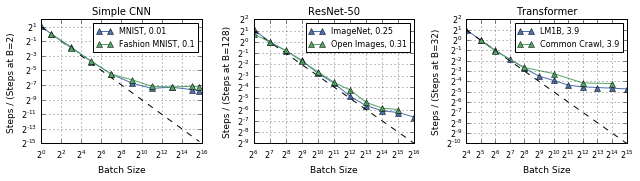

In [21]:
#@title Figure 5

fig, axes = create_subplots(1, 3)

# Simple CNN on different data sets.
steps_to_result = collections.OrderedDict()
_, workload_table = load_workload(os.path.join(DATA_DIR, "mnist/simple_cnn_base/nesterov_momentum"), num_trials=100)
steps_to_result["MNIST, 0.01"] = compute_steps_to_result(workload_table, "val/classification_error", 0.01)
_, workload_table = load_workload(os.path.join(DATA_DIR, "fashion_mnist/simple_cnn_base/nesterov_momentum"), num_trials=100)
steps_to_result["Fashion MNIST, 0.1"] = compute_steps_to_result(workload_table, "val/classification_error", 0.1)
plot_steps_to_result(axes[0], steps_to_result, scaling_label="MNIST, 0.01", normalizing_batch_size=2)
axes[0].set_title("Simple CNN")
axes[0].legend()

# ResNet-50 on different data sets.
steps_to_result = collections.OrderedDict()
workload_dir = os.path.join(DATA_DIR, "imagenet/resnet_50/nesterov_momentum")
_, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result["ImageNet, 0.25"] = compute_steps_to_result(workload_table, "val/classification_error", 0.25)
workload_dir = os.path.join(DATA_DIR, "open_images_v4/resnet_50/nesterov_momentum")
_, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result["Open Images, 0.31"] = compute_steps_to_result(workload_table, "val/average_precision", 0.31, maximize=True)
plot_steps_to_result(axes[1], steps_to_result, scaling_label="ImageNet, 0.25", normalizing_batch_size=128)
axes[1].set_title("ResNet-50")
axes[1].legend()

# Transformer on different data sets.
steps_to_result = collections.OrderedDict()
workload_dir = os.path.join(DATA_DIR, "lm1b/transformer_base/nesterov_momentum")
_, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result["LM1B, 3.9"] = compute_steps_to_result(workload_table, "val/cross_entropy_error", 3.9)
workload_dir = os.path.join(DATA_DIR, "common_crawl/transformer_base/nesterov_momentum")
_, workload_table = load_workload(workload_dir, num_trials=50)
steps_to_result["Common Crawl, 3.9"] = compute_steps_to_result(workload_table, "val/cross_entropy_error", 3.9)
plot_steps_to_result(axes[2], steps_to_result, scaling_label="LM1B, 3.9", normalizing_batch_size=32)
axes[2].set_title("Transformer")
axes[2].legend()

plt.tight_layout()

Loaded 17 batch sizes for simple_cnn_base on mnist_55000 with optimizer nesterov_momentum
Loaded 16 batch sizes for simple_cnn_base on mnist_27500 with optimizer nesterov_momentum
Loaded 15 batch sizes for simple_cnn_base on mnist_13750 with optimizer nesterov_momentum
Loaded 14 batch sizes for simple_cnn_base on mnist_6875 with optimizer nesterov_momentum
Loaded 11 batch sizes for resnet_50 on imagenet with optimizer nesterov_momentum
Loaded 10 batch sizes for resnet_50 on imagenet_half_images with optimizer nesterov_momentum
Loaded 10 batch sizes for resnet_50 on imagenet_half_classes with optimizer nesterov_momentum


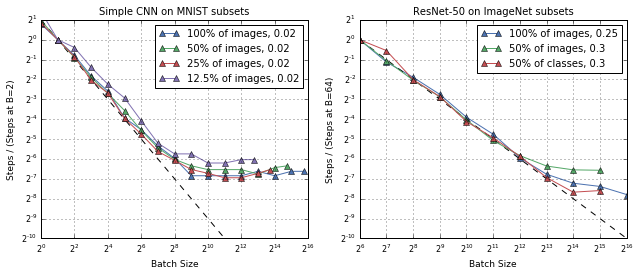

In [22]:
#@title Figure 6

fig, axes = create_subplots(1, 2)

# Simple CNN on MNIST subsets.
steps_to_result = collections.OrderedDict()
for name, subdir, threshold in [("100% of images", "mnist_subsets/mnist_55000/simple_cnn_base/nesterov_momentum", 0.02),
                                ("50% of images", "mnist_subsets/mnist_27500/simple_cnn_base/nesterov_momentum", 0.02),
                                ("25% of images", "mnist_subsets/mnist_13750/simple_cnn_base/nesterov_momentum", 0.02),
                                ("12.5% of images", "mnist_subsets/mnist_6875/simple_cnn_base/nesterov_momentum", 0.02)]:
  label = "{}, {}".format(name, threshold)
  _, workload_table = load_workload(os.path.join(DATA_DIR, subdir), num_trials=100)
  steps_to_result[label] = compute_steps_to_result(workload_table, "val/classification_error", 0.02)
plot_steps_to_result(axes[0], steps_to_result, scaling_label="100% of images, 0.02", normalizing_batch_size=2)
axes[0].set_title("Simple CNN on MNIST subsets")
axes[0].set_ylim([2**-10, 2])
axes[0].legend(fontsize=10)

# ResNet-50 on ImageNet subsets.
steps_to_result = collections.OrderedDict()
for name, subdir, threshold in [("100% of images", "imagenet/resnet_50/nesterov_momentum", 0.25),
                                ("50% of images", "imagenet_subsets/imagenet_half_images/resnet_50/nesterov_momentum", 0.3),
                                ("50% of classes", "imagenet_subsets/imagenet_half_classes/resnet_50/nesterov_momentum", 0.3)]:
  label = "{}, {}".format(name, threshold)
  _, workload_table = load_workload(os.path.join(DATA_DIR, subdir), num_trials=100)
  steps_to_result[label] = compute_steps_to_result(workload_table, "val/classification_error", threshold)
plot_steps_to_result(axes[1], steps_to_result, scaling_label="100% of images, 0.25", normalizing_batch_size=64)
axes[1].set_title("ResNet-50 on ImageNet subsets")
axes[1].set_ylim([2**-10, 2])
axes[1].legend(fontsize=10)

plt.tight_layout()

Loaded 11 batch sizes for resnet_50 on imagenet with optimizer nesterov_momentum


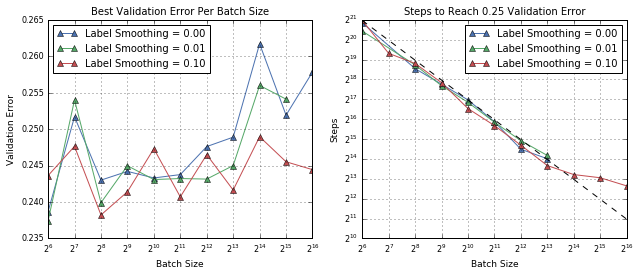

In [23]:
#@title Figure 7

fig, axes = create_subplots(1, 2)

# Read trials and partition by the label smoothing parameter.
workload_dir = os.path.join(DATA_DIR, "imagenet/resnet_50/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir, num_trials=100)
trials_by_label_smoothing = collections.defaultdict(list)
for batch_size in workload_metadata:
  for trial_id, trial_metadata in workload_metadata[batch_size]["trials"].items():
    label_smoothing = "{:.2f}".format(trial_metadata["parameters"].get("label_smoothing", 0.0))
    trials_by_label_smoothing[label_smoothing].append(workload_table.loc[batch_size, trial_id, :])
assert set(trials_by_label_smoothing.keys()) == {"0.00", "0.01", "0.10"}

# Collect the best objective per batch size and steps to result for each value
# of the label smoothing parameter.
best_measurements = collections.OrderedDict()
steps_to_result = collections.OrderedDict()
for label_smoothing in ["0.00", "0.01", "0.10"]:
  filtered_workload_table = pd.concat(trials_by_label_smoothing[label_smoothing])
  label = "Label Smoothing = " + label_smoothing
  best_measurements[label] = get_best_measurement(filtered_workload_table, "val/classification_error")
  steps_to_result[label] = compute_steps_to_result(filtered_workload_table, "val/classification_error", 0.25)

# Plot best validation error per batch size and steps to result.
plot_best_measurements(axes[0], best_measurements, "val/classification_error")
axes[0].set_title("Best Validation Error Per Batch Size")
axes[0].set_ylabel("Validation Error")
axes[0].legend(loc="upper left", fontsize=10)

plot_steps_to_result(axes[1], steps_to_result, scaling_label="Label Smoothing = 0.10")
axes[1].set_title("Steps to Reach 0.25 Validation Error")
axes[1].legend(fontsize=10)

plt.tight_layout()

Loaded 10 batch sizes for simple_cnn_base on mnist with optimizer nesterov_momentum
Loaded 9 batch sizes for simple_cnn_base on fashion_mnist with optimizer nesterov_momentum
Loaded 13 batch sizes for resnet_8 on cifar_10 with optimizer nesterov_momentum
Loaded 11 batch sizes for resnet_50 on imagenet with optimizer nesterov_momentum
Loaded 10 batch sizes for resnet_50 on open_images_v4 with optimizer nesterov_momentum
Loaded 12 batch sizes for transformer_base on lm1b with optimizer nesterov_momentum
Loaded 6 batch sizes for transformer_base on common_crawl with optimizer nesterov_momentum
Loaded 11 batch sizes for vgg_11 on imagenet with optimizer nesterov_momentum
Loaded 7 batch sizes for lstm on lm1b with optimizer nesterov_momentum


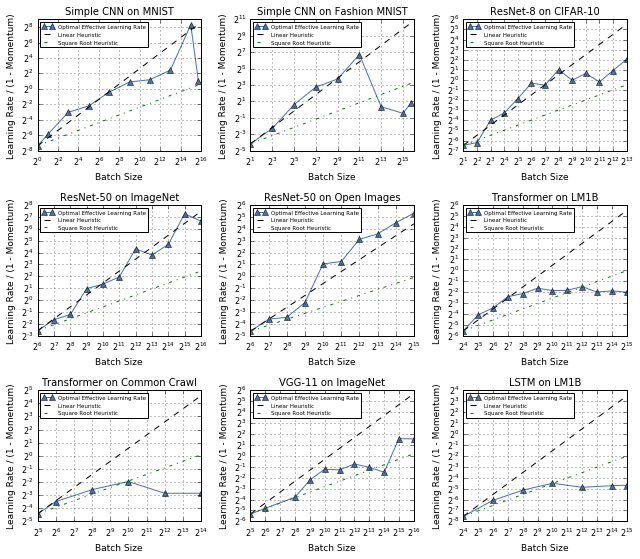

In [24]:
#@title Figure 8

fig, axes = create_subplots(3, 3)

# Simple CNN on MNIST.
workload_dir = os.path.join(DATA_DIR, "mnist/simple_cnn_base/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result = compute_steps_to_result(workload_table, "val/classification_error", 0.01)
plot_optimal_metaparameter_values(axes[0][0], "Effective Learning Rate", steps_to_result, workload_metadata)
axes[0][0].set_title("Simple CNN on MNIST")
axes[0][0].legend(loc="upper left", fontsize=5.5)

# Simple CNN on Fashion MNIST.
workload_dir = os.path.join(DATA_DIR, "fashion_mnist/simple_cnn_base/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result = compute_steps_to_result(workload_table, "val/classification_error", 0.3)
plot_optimal_metaparameter_values(axes[0][1], "Effective Learning Rate", steps_to_result, workload_metadata)
axes[0][1].set_title("Simple CNN on Fashion MNIST")
axes[0][1].legend(loc="upper left", fontsize=5.5)

# ResNet-8 on CIFAR-10.
workload_dir = os.path.join(DATA_DIR, "cifar_10/resnet_8/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result = compute_steps_to_result(workload_table, "val/classification_error", 0.3)
plot_optimal_metaparameter_values(axes[0][2], "Effective Learning Rate", steps_to_result, workload_metadata)
axes[0][2].set_title("ResNet-8 on CIFAR-10")
axes[0][2].legend(loc="upper left", fontsize=5.5)

# ResNet-50 on ImageNet.
workload_dir = os.path.join(DATA_DIR, "imagenet/resnet_50/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result = compute_steps_to_result(workload_table, "val/classification_error", 0.25)
plot_optimal_metaparameter_values(axes[1][0], "Effective Learning Rate", steps_to_result, workload_metadata)
axes[1][0].set_title("ResNet-50 on ImageNet")
axes[1][0].legend(loc="upper left", fontsize=5.5)

# ResNet-50 on Open Images.
workload_dir = os.path.join(DATA_DIR, "open_images_v4/resnet_50/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result = compute_steps_to_result(workload_table, "val/average_precision", 0.31, maximize=True)
plot_optimal_metaparameter_values(axes[1][1], "Effective Learning Rate", steps_to_result, workload_metadata)
axes[1][1].set_title("ResNet-50 on Open Images")
axes[1][1].legend(loc="upper left", fontsize=5.5)

# Transformer on LM1B.
workload_dir = os.path.join(DATA_DIR, "lm1b/transformer_base/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result = compute_steps_to_result(workload_table, "val/cross_entropy_error", 3.9)
plot_optimal_metaparameter_values(axes[1][2], "Effective Learning Rate", steps_to_result, workload_metadata)
axes[1][2].set_title("Transformer on LM1B")
axes[1][2].legend(loc="upper left", fontsize=5.5)

# Transformer on Common Crawl.
workload_dir = os.path.join(DATA_DIR, "common_crawl/transformer_base/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir, num_trials=50)
steps_to_result = compute_steps_to_result(workload_table, "val/cross_entropy_error", 3.9)
plot_optimal_metaparameter_values(axes[2][0], "Effective Learning Rate", steps_to_result, workload_metadata)
axes[2][0].set_title("Transformer on Common Crawl")
axes[2][0].legend(loc="upper left", fontsize=5.5)

# VGG-11 on ImageNet.
workload_dir = os.path.join(DATA_DIR, "imagenet/vgg_11/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir, num_trials=100)
steps_to_result = compute_steps_to_result(workload_table, "val/classification_error", 0.35)
plot_optimal_metaparameter_values(axes[2][1], "Effective Learning Rate", steps_to_result, workload_metadata)
axes[2][1].set_title("VGG-11 on ImageNet")
axes[2][1].legend(loc="upper left", fontsize=5.5)

# LSTM on LM1B.
workload_dir = os.path.join(DATA_DIR, "lm1b/lstm/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir, num_trials=50)
steps_to_result = compute_steps_to_result(workload_table, "val/cross_entropy_error", 3.9)
plot_optimal_metaparameter_values(axes[2][2], "Effective Learning Rate", steps_to_result, workload_metadata)
axes[2][2].set_title("LSTM on LM1B")
axes[2][2].legend(loc="upper left", fontsize=5.5)

plt.tight_layout()

Loaded 12 batch sizes for transformer_base on lm1b with optimizer nesterov_momentum


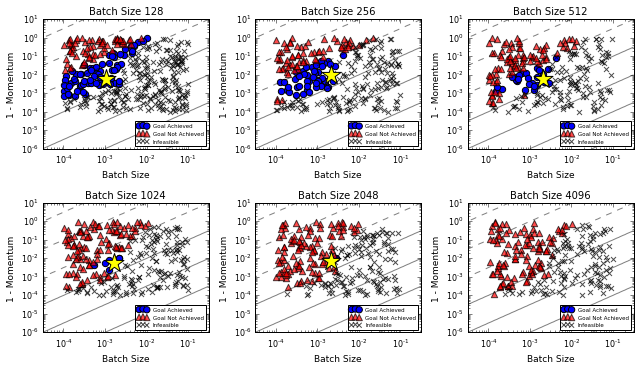

In [25]:
#@title Figure 9a

fig, axes = create_subplots(2, 3)
axes = np.reshape(axes, -1)

workload_dir = os.path.join(DATA_DIR, "lm1b/transformer_base/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir, load_infeasible_trials=True)

batch_sizes = [128, 256, 512, 1024, 2048, 4096]
for batch_size, ax in zip(batch_sizes, axes):
  step_budget = 30301028 / batch_size
  study_table = apply_step_budget(workload_table.loc[batch_size], step_budget)
  plot_learning_rate_momentum_scatter(
      ax,
      objective_col_name="val/cross_entropy_error",
      objective_goal=3.9,
      study_table=study_table,
      study_metadata=workload_metadata[batch_size],
      xlim=[10**-4.5, 10**-0.5],
      ylim=[10**-6, 10**1])
  ax.set_title("Batch Size {}".format(batch_size))
  ax.legend(loc="lower right", fontsize=5.5)
  
plt.tight_layout()

Loaded 12 batch sizes for transformer_base on lm1b with optimizer nesterov_momentum


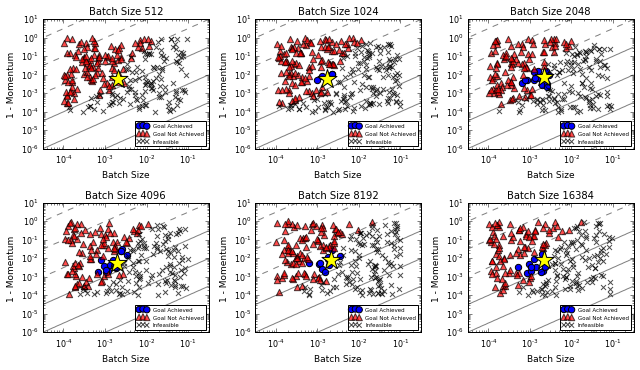

In [26]:
#@title Figure 9b

fig, axes = create_subplots(2, 3)
axes = np.reshape(axes, -1)

workload_dir = os.path.join(DATA_DIR, "lm1b/transformer_base/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir, load_infeasible_trials=True)

step_budget = 25000
batch_sizes = [512, 1024, 2048, 4096, 8192, 16384]
for batch_size, ax in zip(batch_sizes, axes):
  study_table = apply_step_budget(workload_table.loc[batch_size], step_budget)
  plot_learning_rate_momentum_scatter(
      ax,
      objective_col_name="val/cross_entropy_error",
      objective_goal=3.9,
      study_table=study_table,
      study_metadata=workload_metadata[batch_size],
      xlim=[10**-4.5, 10**-0.5],
      ylim=[10**-6, 10**1])
  ax.set_title("Batch Size {}".format(batch_size))
  ax.legend(loc="lower right", fontsize=5.5)
  
plt.tight_layout()

Loaded 12 batch sizes for transformer_wide on lm1b with optimizer nesterov_momentum
Loaded 12 batch sizes for transformer_base on lm1b with optimizer nesterov_momentum
Loaded 12 batch sizes for transformer_shallow on lm1b with optimizer nesterov_momentum
Loaded 12 batch sizes for transformer_narrow_and_shallow on lm1b with optimizer nesterov_momentum


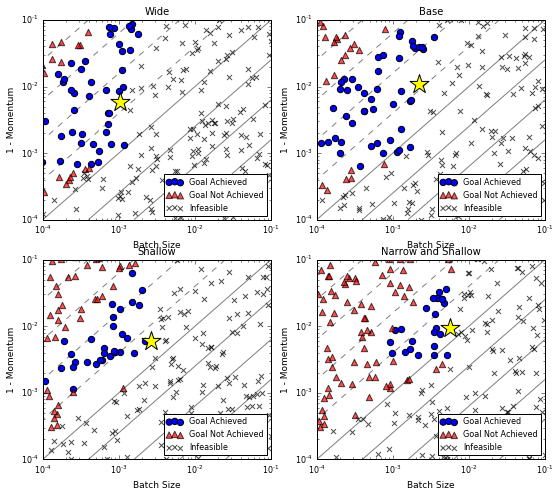

In [27]:
#@title Figure 10

fig, axes = create_subplots(2, 2)
axes = np.reshape(axes, -1)

batch_size = 1024
step_budget = 50000
title_and_model = [
    ("Wide", "transformer_wide"),
    ("Base", "transformer_base"),
    ("Shallow", "transformer_shallow"),
    ("Narrow and Shallow", "transformer_narrow_and_shallow")
]
for ax, (title, model) in zip(axes, title_and_model):
  workload_dir = os.path.join(DATA_DIR, "lm1b/{}/nesterov_momentum".format(model))
  workload_metadata, workload_table = load_workload(workload_dir, load_infeasible_trials=True)
  study_table = apply_step_budget(workload_table.loc[batch_size], step_budget)
  plot_learning_rate_momentum_scatter(
      ax,
      objective_col_name="val/cross_entropy_error",
      objective_goal=4.2,
      study_table=study_table,
      study_metadata=workload_metadata[batch_size],
      xlim=[10**-4, 10**-1],
      ylim=[10**-4, 10**-1])
  ax.set_title(title)
  ax.legend(loc="lower right", fontsize=8)

Loaded 10 batch sizes for simple_cnn_base on mnist with optimizer nesterov_momentum
Loaded 10 batch sizes for simple_cnn_base on fashion_mnist with optimizer nesterov_momentum
Loaded 12 batch sizes for transformer_narrow_and_shallow on lm1b with optimizer nesterov_momentum
Loaded 12 batch sizes for transformer_base on lm1b with optimizer nesterov_momentum


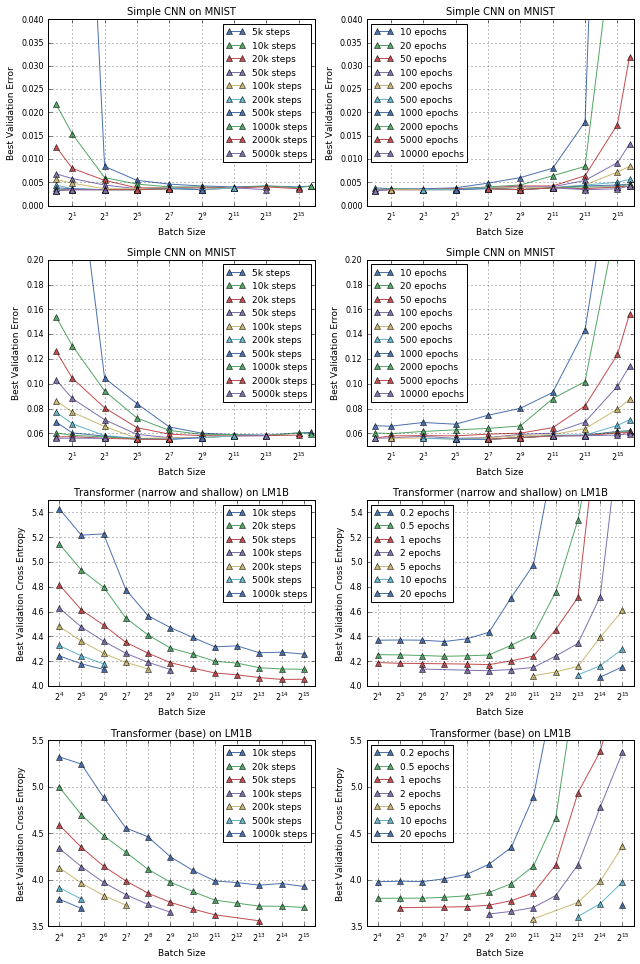

In [30]:
#@title Figure 11

fig, axes = create_subplots(4, 2, subplot_aspect_ratio=4/3)

# Simple CNN on MNIST
workload_dir = os.path.join(DATA_DIR, "solution_quality/mnist/simple_cnn_base/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir)
training_set_size = 55000
objective_col_name = "val/classification_error"
title = "Simple CNN on MNIST"
ylabel = "Best Validation Error"

best_measurements = collections.OrderedDict()
for step_budget_ksteps in [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]:
  step_budget = 1000 * step_budget_ksteps
  label = "{}k steps".format(step_budget_ksteps)
  batch_sizes = [b for b in workload_metadata if workload_metadata[b]["train_steps"] >= step_budget]
  filtered_workload_table = apply_step_budget(workload_table.loc[batch_sizes], step_budget)
  best_measurements[label] = get_best_measurement(filtered_workload_table, objective_col_name)
plot_best_measurements(axes[0][0], best_measurements, objective_col_name)
axes[0][0].set_title(title)
axes[0][0].set_xlim([2**-0.5, 2**16])
axes[0][0].set_ylim([0, 0.04])
axes[0][0].set_ylabel(ylabel)
axes[0][0].legend(loc="upper right", fontsize=9)

best_measurements = collections.OrderedDict()
for epoch_budget in [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]:
  label = "{} epochs".format(epoch_budget)
  batch_sizes = [b for b in workload_metadata if workload_metadata[b]["train_steps"] >= epoch_budget * training_set_size / b]
  filtered_workload_table = apply_example_budget(workload_table.loc[batch_sizes], epoch_budget * training_set_size)
  best_measurements[label] = get_best_measurement(filtered_workload_table, objective_col_name)
plot_best_measurements(axes[0][1], best_measurements, objective_col_name)
axes[0][1].set_title(title)
axes[0][1].set_xlim([2**-0.5, 2**16])
axes[0][1].set_ylim([0, 0.04])
axes[0][1].set_ylabel(ylabel)
axes[0][1].legend(loc="upper left", fontsize=9)

# Simple CNN on Fashion MNIST
workload_dir = os.path.join(DATA_DIR, "solution_quality/fashion_mnist/simple_cnn_base/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir)
training_set_size = 55000
objective_col_name = "val/classification_error"
title = "Simple CNN on MNIST"
ylabel = "Best Validation Error"

best_measurements = collections.OrderedDict()
for step_budget_ksteps in [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]:
  step_budget = 1000 * step_budget_ksteps
  label = "{}k steps".format(step_budget_ksteps)
  batch_sizes = [b for b in workload_metadata if workload_metadata[b]["train_steps"] >= step_budget]
  filtered_workload_table = apply_step_budget(workload_table.loc[batch_sizes], step_budget)
  best_measurements[label] = get_best_measurement(filtered_workload_table, objective_col_name)
plot_best_measurements(axes[1][0], best_measurements, objective_col_name)
axes[1][0].set_title(title)
axes[1][0].set_xlim([2**-0.5, 2**16])
axes[1][0].set_ylim([0.05, 0.2])
axes[1][0].set_ylabel(ylabel)
axes[1][0].legend(loc="upper right", fontsize=9)

best_measurements = collections.OrderedDict()
for epoch_budget in [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]:
  label = "{} epochs".format(epoch_budget)
  batch_sizes = [b for b in workload_metadata if workload_metadata[b]["train_steps"] >= epoch_budget * training_set_size / b]
  filtered_workload_table = apply_example_budget(workload_table.loc[batch_sizes], epoch_budget * training_set_size)
  best_measurements[label] = get_best_measurement(filtered_workload_table, objective_col_name)
plot_best_measurements(axes[1][1], best_measurements, objective_col_name)
axes[1][1].set_title(title)
axes[1][1].set_xlim([2**-0.5, 2**16])
axes[1][1].set_ylim([0.05, 0.2])
axes[1][1].set_ylabel(ylabel)
axes[1][1].legend(loc="upper left", fontsize=9)

# Transformer narrow and shallow on LM1B.
workload_dir = os.path.join(DATA_DIR, "lm1b/transformer_narrow_and_shallow/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir)
training_set_size = 30301028
objective_col_name = "val/cross_entropy_error"
title = "Transformer (narrow and shallow) on LM1B"
ylabel = "Best Validation Cross Entropy"

best_measurements = collections.OrderedDict()
for step_budget_ksteps in [10, 20, 50, 100, 200, 500, 1000]:
  step_budget = 1000 * step_budget_ksteps
  label = "{}k steps".format(step_budget_ksteps)
  batch_sizes = [b for b in workload_metadata if workload_metadata[b]["train_steps"] >= step_budget]
  filtered_workload_table = apply_step_budget(workload_table.loc[batch_sizes], step_budget)
  best_measurements[label] = get_best_measurement(filtered_workload_table, objective_col_name)
plot_best_measurements(axes[2][0], best_measurements, objective_col_name)
axes[2][0].set_title(title)
axes[2][0].set_xlim([2**3.5, 2**15.5])
axes[2][0].set_ylim([4.0, 5.5])
axes[2][0].set_ylabel(ylabel)
axes[2][0].legend(loc="upper right", fontsize=9)

best_measurements = collections.OrderedDict()
for epoch_budget in [0.2, 0.5, 1, 2, 5, 10, 20]:
  label = "{} epochs".format(epoch_budget)
  batch_sizes = [b for b in workload_metadata if workload_metadata[b]["train_steps"] >= epoch_budget * training_set_size / b]
  filtered_workload_table = apply_example_budget(workload_table.loc[batch_sizes], epoch_budget * training_set_size)
  best_measurements[label] = get_best_measurement(filtered_workload_table, objective_col_name)
plot_best_measurements(axes[2][1], best_measurements, objective_col_name)
axes[2][1].set_title(title)
axes[2][1].set_xlim([2**3.5, 2**15.5])
axes[2][1].set_ylim([4.0, 5.5])
axes[2][1].set_ylabel(ylabel)
axes[2][1].legend(loc="upper left", fontsize=9)

# Transformer base on LM1B.
workload_dir = os.path.join(DATA_DIR, "lm1b/transformer_base/nesterov_momentum")
workload_metadata, workload_table = load_workload(workload_dir)
training_set_size = 30301028
objective_col_name = "val/cross_entropy_error"
title = "Transformer (base) on LM1B"
ylabel = "Best Validation Cross Entropy"

best_measurements = collections.OrderedDict()
for step_budget_ksteps in [10, 20, 50, 100, 200, 500, 1000]:
  step_budget = 1000 * step_budget_ksteps
  label = "{}k steps".format(step_budget_ksteps)
  batch_sizes = [b for b in workload_metadata if workload_metadata[b]["train_steps"] >= step_budget]
  filtered_workload_table = apply_step_budget(workload_table.loc[batch_sizes], step_budget)
  best_measurements[label] = get_best_measurement(filtered_workload_table, objective_col_name)
plot_best_measurements(axes[3][0], best_measurements, objective_col_name)
axes[3][0].set_title(title)
axes[3][0].set_xlim([2**3.5, 2**15.5])
axes[3][0].set_ylim([3.5, 5.5])
axes[3][0].set_ylabel(ylabel)
axes[3][0].legend(loc="upper right", fontsize=9)

best_measurements = collections.OrderedDict()
for epoch_budget in [0.2, 0.5, 1, 2, 5, 10, 20]:
  label = "{} epochs".format(epoch_budget)
  batch_sizes = [b for b in workload_metadata if workload_metadata[b]["train_steps"] >= epoch_budget * training_set_size / b]
  filtered_workload_table = apply_example_budget(workload_table.loc[batch_sizes], epoch_budget * training_set_size)
  best_measurements[label] = get_best_measurement(filtered_workload_table, objective_col_name)
plot_best_measurements(axes[3][1], best_measurements, objective_col_name)
axes[3][1].set_title(title)
axes[3][1].set_xlim([2**3.5, 2**15.5])
axes[3][1].set_ylim([3.5, 5.5])
axes[3][1].set_ylabel(ylabel)
axes[3][1].legend(loc="upper left", fontsize=9)
  
plt.tight_layout()